In [1]:
from scipy.linalg import eigh
from scipy.sparse import diags
from scipy.interpolate import interp1d
from scipy.integrate import quad

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

np.set_printoptions(precision=3, suppress=True)

In [2]:
def discrete_bloch(x, V, q):
    
    dx = x[1] - x[0]    

    KE_particle = diags(
        [
            -1/dx**2 * np.ones(len(x)-1), 
            2/dx**2 * np.ones(len(x)), 
            -1/dx**2 * np.ones(len(x)-1)

        ], [-1, 0, 1])

    KE_lattice = diags(q**2 * np.ones(len(x)), 0)

    KE_cross = -2j * q * diags(
        [
            -1/(2*dx) * np.ones(len(x)-1), 
            1/(2*dx) * np.ones(len(x)-1)
        
        ], [-1, 1])

    Hamiltonian = (KE_particle + KE_lattice + KE_cross + diags(V, 0)).todense()
    Hamiltonian[0, -1] = Hamiltonian[-1, 0] = -1/dx**2

    E, phi = eigh(Hamiltonian) # evals, evecs

    return np.real(E), phi.T/np.sqrt((dx * np.sum(np.abs(phi.T)**2, axis = 0)))

In [108]:
x = np.linspace(0, 1, 1001)
def potential(x):
    return -2000 * np.sin(np.pi * x) ** 2

V = np.vectorize(potential)(x)
dx = x[1] - x[0]

In [123]:
# First Brillouin Zone
q = np.linspace(-200 * np.pi, 200 * np.pi, 50)

# Bloch u_k(x) and energies E_k
psi = np.empty((len(q), len(x), len(x)), dtype = np.complex128)
E = np.empty((len(q), len(x)), dtype = np.complex128)

In [125]:
for i, k in tqdm(enumerate(q)):
    E[i], psi[i] = discrete_bloch(x, V, k)

0it [00:00, ?it/s]

In [90]:
def get_wannier(bloch, k, x, R, band_num):
    N = len(k)
    return 1/np.sqrt(N) * np.sum(np.multiply(bloch[:, band_num, :], np.exp(1j * np.outer(k, x - R)[0])), axis = 0)

In [71]:
# # k is index of wave-number
def func_bloch(discrete_bloch, x, k, band_num):
    return lambda r: interp1d(x, discrete_bloch[k, band_num, :])(r % 1)

# # k is index of wave-number
# def func_bloch(discrete_bloch, x, k, band_num):
#     return lambda r: interp1d(x, discrete_bloch(r % 1)

In [72]:
def func_wannier(discrete_bloch, k, x, R, band_num):
    N = len(k)
    def func(r):
        bloch_vals = np.array([func_bloch(discrete_bloch, x, elt, band_num)(r) for elt in range(len(k))])
        return 1/np.sqrt(N) * np.sum(bloch_vals * np.exp(1j * k * (r - R)), axis = 0)

    return func

In [73]:
wannier = func_wannier(psi, q, x, 0.5, 0)
bloch = func_bloch(psi, x, 13, 0)


C:\Users\saksh\AppData\Local\Temp/ipykernel_14220/1457836690.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  plt.plot(x_grid, np.abs(np.vectorize(wannier)(x_grid))**2/quad(lambda x: np.abs(wannier(x))**2, 0, 1)[0], c = "C17", label = "Wannier")


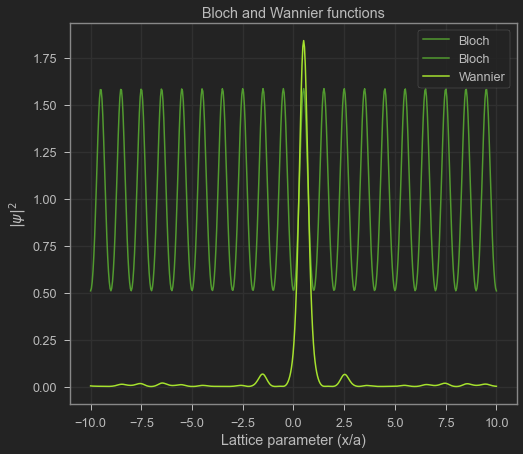

In [74]:
x_grid = np.linspace(-10, 10, 500)
plt.plot(x_grid, np.abs(np.vectorize(bloch)(x_grid))**2, dx, c= "C15", label = "Bloch")
plt.plot(x_grid, np.abs(np.vectorize(wannier)(x_grid))**2/quad(lambda x: np.abs(wannier(x))**2, 0, 1)[0], c = "C17", label = "Wannier")
# plt.plot(x_grid, np.abs(np.vectorize(wannier)(x_grid))**2, c = "C17", label = "Wannier")
plt.xlabel("Lattice parameter (x/a)")
plt.ylabel("$|\psi|^2$")
plt.title("Bloch and Wannier functions")
# plt.legend(bbox_to_anchor=(1.025, 1.015))
plt.legend()


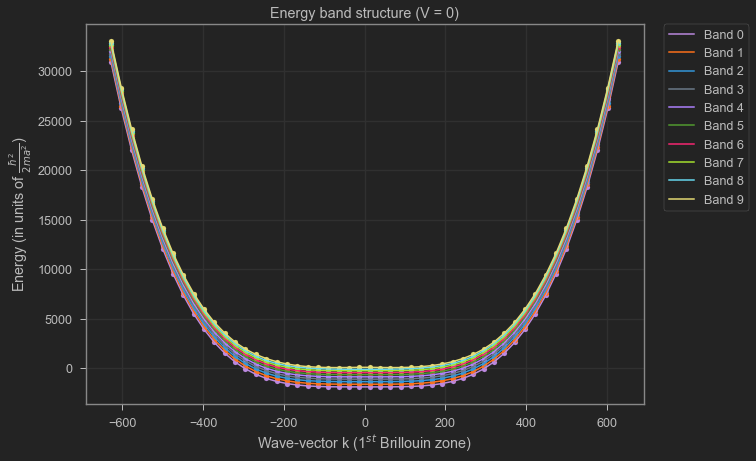

In [130]:
fig = plt.figure(figsize=(10, 7))

for i in range(10):
    plt.plot(q, np.real(E)[:, i], c = f"C{10+i}", zorder = 5, label = f"Band {i}")
    plt.scatter(q, np.real(E)[:, i], c = f"C{10+i}", zorder = 5, s = 25)


ax = plt.gca()
ax.set_xlabel(r"Wave-vector k (1$^{st}$ Brillouin zone)")
ax.set_ylabel(r"Energy (in units of $\frac{\hbar^2}{2ma^2}$)")
ax.set_title("Energy band structure (V = 0)")

ax.legend(bbox_to_anchor=(1.025, 1.015))

# left, bottom, width, height = [0.436, 0.45, 0.15, 0.3]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(x, V, c = "C4", label = "Potential")
# ax2.set_title("Periodic Potential")